# Processing data

The goal is to create new cleaned data files.

In [1]:
import os
import time

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from fault_management_uds.data.load import import_external_metadata, load_data_period
from fault_management_uds.data.process import ensure_data_is_from_start_to_end, remove_nans_from_start_end
from fault_management_uds.config import DATA_DIR, RAW_DATA_DIR, INTERIM_DATA_DIR, PROCESSED_DATA_DIR, EXTERNAL_DATA_DIR
from fault_management_uds.config import MODELS_DIR, REPORTS_DIR, FIGURES_DIR, REFERENCE_DIR


scripts_path = EXTERNAL_DATA_DIR / 'Bellinge' / 'scripts'
sensor_data_path = EXTERNAL_DATA_DIR / 'Bellinge' / 'sensor-data'

2024-11-10 20:21:27.761 | INFO     | fault_management_uds.config:<module>:11 - PROJ_ROOT path is: /Users/arond.jacobsen/Documents/GitHub/fault_management_uds


In [2]:
runtime_start = time.time()

---
# TODO:

- set appropriate conversion on sensor data based on its scale, now all meter
    - it can also affect the rounding of the data

---

## Load

In [3]:
scripts_path

PosixPath('/Users/arond.jacobsen/Documents/GitHub/fault_management_uds/data/external/Bellinge/scripts')

In [4]:
metadata, manual_remove = import_external_metadata(scripts_path)

print(metadata.columns)
print(metadata.shape)
metadata.head()

Index(['IdMeasurement', 'Area', 'Source', 'Version', 'Type', 'Folderpath',
       'Filename', 'TagSRO', 'Navn', 'StartTime', 'EndTime', 'Conversion',
       'comment', 'unit', 'obvious_min', 'obvious_max', 'zeropoint',
       'window_frozen', 'outlier_threshold', 'outlier_width'],
      dtype='object')
(36, 20)


,IdMeasurement,Area,Source,Version,Type,Folderpath,Filename,TagSRO,Navn,StartTime,EndTime,Conversion,comment,unit,obvious_min,obvious_max,zeropoint,window_frozen,outlier_threshold,outlier_width
31,G71F04R_Level1,Bellinge,System2000,p1,Level,./2_raw_data/,data-pG71F04R-D1-W1-BL3_M2-PV-SMO.txt,G71F04R-D1-W1-BL3_M2-PV-SMO,Niv. Indløb 1,2010-08-01,2020-01-06,100.000000,cm -> m,cm,0.001,1.5,17.09,20,0.2,1
4,G71F04R_Level1,Bellinge,System2000,p2,Level,./2_raw_data/,data-pG71F04R-D1-W1-BL3_M2-PV-SMO_red.txt,G71F04R-D1-W1-BL3_M2-PV-SMO,Niv. Indløb 1,2020-01-06,2020-10-12,68.965517,cm -> m + scaling factor wrong initially (2.9/2),cm,0.001,1.5,17.09,20,0.2,1
2,G71F04R_Level1,Bellinge,iFix,p3,Level,./2_raw_data/,SVTP03.G71F04R-D1-W1-BL3!M5-PV-SMO.F_CV_red.rpt,SVTP03.G71F04R-D1-W1-BL3!M5-PV-SMO.F_CV,Niv. Indløb 1,2020-10-12,2020-11-19,0.689655,scaling factor wrong initially,cm,0.001,1.5,17.09,20,0.2,1
0,G71F04R_Level1,Bellinge,iFix,p4,Level,./2_raw_data/,SVTP03.G71F04R-D1-W1-BL3!M5-PV-SMO.F_CV.rpt,SVTP03.G71F04R-D1-W1-BL3!M5-PV-SMO.F_CV,Niv. Indløb 1,2020-11-19,2021-08-19,1.000000,NaN,m,0.001,1.5,17.09,20,0.2,1
32,G71F04R_Level2,Bellinge,System2000,p1,Level,./2_raw_data/,data-pG71F04R-D1-W1-BL4_M2-PV-SMO.txt,G71F04R-D1-W1-BL4_M2-PV-SMO,Niv. Indløb 2,2010-08-01,2020-01-06,100.000000,cm -> m,cm,0.001,1.5,17.05,20,0.2,1


In [5]:
metadata['Conversion'].isna().sum()   

0

In [6]:
metadata['Conversion'].unique().tolist()

[100.0, 68.96551724, 0.689655172, 1.0, 3600.0]

In [7]:
metadata['obvious_min'].isna().sum()    

0

In [8]:
for minimum, group in metadata.groupby('obvious_min'):
    print(f"minimum: {minimum}")
    print(f"    units: {group['unit'].unique()}")
    print(f"    comments: {group['comment'].unique()}")


minimum: -5.0
    units: ['m3/h']
    comments: ['m3/h -> m3/s']
minimum: 0.0
    units: ['cm' 'A' nan]
    comments: ['cm -> m' nan]
minimum: 0.001
    units: ['cm' 'm' nan]
    comments: ['cm -> m' 'cm -> m + scaling factor wrong initially (2.9/2)'
 'scaling factor wrong initially' nan
 'cm -> m + scaling factor wrong initially']
minimum: 0.002
    units: ['cm']
    comments: ['cm -> m' nan]


- rounding to 0.001 (3 decimals) seems applicable in all cases for capturing the obvious minimum - and it is wrt post conversion
    - 0.001 meter is 1 mm
    - 0.001 m3/s is 1 l/s
    - 0.001 A is 1 mA
    - negative flow, becaouse it can be in the other direction?

In [9]:
not_check_unique = ['IdMeasurement', 'Folderpath', 'Filename', 'TagSRO', 'Navn', 'sensor_orientation']
for i, col in enumerate(metadata.columns):
    if col not in not_check_unique:
        print(f"{col}: {metadata[col].unique()}")
        print('')

Area: ['Bellinge']

Source: ['System2000' 'iFix' 'Danova']

Version: ['p1' 'p2' 'p3' 'p4']

Type: ['Level' 'Position' 'Discharge' 'Power']

StartTime: <DatetimeArray>
['2010-08-01 00:00:00', '2020-01-06 00:00:00', '2020-10-12 00:00:00',
 '2020-11-19 00:00:00', '2020-10-13 00:00:00', '2017-03-07 00:00:00',
 '2020-01-08 00:00:00', '2019-06-27 00:00:00', '2019-10-23 00:00:00',
 '2010-01-01 00:00:00', '2018-09-05 00:00:00']
Length: 11, dtype: datetime64[ns]

EndTime: <DatetimeArray>
['2020-01-06 00:00:00', '2020-10-12 00:00:00', '2020-11-19 00:00:00',
 '2021-08-19 00:00:00', '2020-03-23 00:00:00', '2018-09-04 00:00:00']
Length: 6, dtype: datetime64[ns]

Conversion: [1.000000e+02 6.896552e+01 6.896552e-01 1.000000e+00 3.600000e+03]

comment: ['cm -> m' 'cm -> m + scaling factor wrong initially (2.9/2)'
 'scaling factor wrong initially' nan
 'cm -> m + scaling factor wrong initially' 'm3/h -> m3/s']

unit: ['cm' 'm' 'm3/h' 'A' nan]

obvious_min: [ 1.e-03  0.e+00  2.e-03 -5.e+00]

obvious_max

In [10]:
# metadata[['IdMeasurement', 'Source', 'Version']]

print(metadata.shape[0])
print(f"NaN for IdMeasurement: {metadata['IdMeasurement'].isna().sum()} || Empty: {metadata[metadata['IdMeasurement'] == ''].shape[0]}")
print(f"NaN for Source: {metadata['Source'].isna().sum()} || Empty: {metadata[metadata['Source'] == ''].shape[0]}")
print(f"NaN for Version: {metadata['Version'].isna().sum()} || Empty: {metadata[metadata['Version'] == ''].shape[0]}")



metadata['SaveName'] = ''

for i, row in metadata.iterrows():
    metadata.loc[i, 'SaveName'] = f"{row['IdMeasurement']}_{row['Source']}_{row['Version']}"

print(metadata['SaveName'].nunique())

36
NaN for IdMeasurement: 0 || Empty: 0
NaN for Source: 0 || Empty: 0
NaN for Version: 0 || Empty: 0
36


Create another save name for the provided cleaned files

In [11]:
provided_processed_path = EXTERNAL_DATA_DIR / 'Bellinge' / 'sensor-data' / '2_cleaned_data' 
provided_processed = os.listdir(provided_processed_path)
# create a new save name for the pre cleaned data
# obs_input.at[i,'IdMeasurement']+"_"+obs_input.at[i,'Source']+obs_input.at[i,'Version'] + "_proc_v6.csv"
metadata['ProvidedSaveName'] = ""
for i in range(len(metadata)):
    cleaned_save_name = metadata.at[i,'IdMeasurement']+"_"+metadata.at[i,'Source']+metadata.at[i,'Version'] + "_proc_v6.csv"
    # Check if the file exists
    if cleaned_save_name in provided_processed:
        metadata.at[i,'ProvidedSaveName'] = cleaned_save_name[:-4]
    else:
        print(f"File {cleaned_save_name} not found")

File G71F68Yp1_power_iFixp1_proc_v6.csv not found
File G71F68Yp2_power_iFixp1_proc_v6.csv not found
File G80F13Pp1_power_iFixp1_proc_v6.csv not found
File G80F13Pp2_power_iFixp1_proc_v6.csv not found
File G71F68Yp1_power_System2000p1_proc_v6.csv not found
File G71F68Yp2_power_System2000p1_proc_v6.csv not found
File G80F13Pp1_power_System2000p1_proc_v6.csv not found
File G80F13Pp2_power_System2000p1_proc_v6.csv not found


In [12]:
metadata['Unit'] = metadata['unit'].copy()
# Based on the table in the pdf on sensor data, we know that all empty values are from mobile sensors or ifix and measured in meters
# Thus fillna with m
metadata['Unit'] = metadata['Unit'].fillna('m')
# if conversion 1 or less keep the same
#metadata.loc[metadata['conversion'] <= 1, 'Unit'] = metadata['unit']

# if conversion is more we know that:
# - cm -> m
# - m3/h -> m3/s
mask = metadata['Conversion'] > 1
metadata.loc[mask, 'Unit'] = metadata.loc[mask, 'unit'].apply(lambda x: x.replace('cm', 'm').replace('m3/h', 'm3/s'))


In [13]:
metadata.iloc[:, [0, 2, 4, 8, 11,12,13, -2, -1]]

,IdMeasurement,Source,Type,Navn,Conversion,comment,unit,ProvidedSaveName,Unit
31,G71F04R_Level1,System2000,Level,Niv. Indløb 1,100.000000,cm -> m,cm,G71F04R_Level1_System2000p1_proc_v6,m
4,G71F04R_Level1,System2000,Level,Niv. Indløb 1,68.965517,cm -> m + scaling factor wrong initially (2.9/2),cm,G71F04R_Level1_System2000p2_proc_v6,m
2,G71F04R_Level1,iFix,Level,Niv. Indløb 1,0.689655,scaling factor wrong initially,cm,G71F04R_Level1_iFixp3_proc_v6,cm
0,G71F04R_Level1,iFix,Level,Niv. Indløb 1,1.000000,NaN,m,G71F04R_Level1_iFixp4_proc_v6,m
32,G71F04R_Level2,System2000,Level,Niv. Indløb 2,100.000000,cm -> m,cm,G71F04R_Level2_System2000p1_proc_v6,m
5,G71F04R_Level2,System2000,Level,Niv. Indløb 2,68.965517,cm -> m + scaling factor wrong initially,cm,G71F04R_Level2_System2000p2_proc_v6,m
3,G71F04R_Level2,iFix,Level,Niv. Indløb 2,0.689655,scaling factor wrong initially,cm,G71F04R_Level2_iFixp3_proc_v6,cm
1,G71F04R_Level2,iFix,Level,Niv. Indløb 2,1.000000,NaN,m,G71F04R_Level2_iFixp4_proc_v6,m
22,G71F05R_LevelBasin,System2000,Level,Niv. Skyllevandsbeh.,100.000000,cm -> m,cm,G71F05R_LevelBasin_System2000p1_proc_v6,m
6,G71F05R_LevelBasin,iFix,Level,Niv. Skyllevandsbeh.,1.000000,NaN,cm,G71F05R_LevelBasin_iFixp1_proc_v6,cm


In [14]:
for sensor_name, group in metadata.groupby('IdMeasurement'):
    if group['Unit'].nunique() > 1:
        print(sensor_name)
        print(group['Unit'].unique())
        print('')

G71F04R_Level1
['m' 'cm']

G71F04R_Level2
['m' 'cm']

G71F05R_LevelBasin
['m' 'cm']

G71F05R_LevelInlet
['m' 'cm']

G71F05R_position
['m' 'cm']

G71F06R_LevelInlet
['m' 'cm']

G71F68Y_LevelPS
['m' 'cm']



lets just convert all cm to m

In [15]:
# if Unit is cm, add 100 to the conversion
mask = metadata['Unit'] == 'cm'

# NOTE: found out that this is not correct! it is already in meters
#metadata.loc[mask, 'Conversion'] = metadata.loc[mask, 'Conversion'] * 100


# set unit to meter
metadata.loc[mask, 'Unit'] = 'm'

In [16]:
# Create a Unit Alias
metadata['UnitAlias'] = metadata['Unit'].copy()
# Create a Unit Alias
replace_dict = {
    'cm': 'Centimeter',
    'm3/h': 'm3/h',
    'm3/s': 'm3/s',
    'm': 'Meter',
    'A': 'Ampere'
}
# add boundaries on the keys
replace_dict = {rf'\b{k}\b': v for k, v in replace_dict.items()}

# Use the replace method with a dictionary
metadata['UnitAlias'] = metadata['Unit'].replace(replace_dict, regex=True)

In [17]:
# Save the metadata as a csv file
metadata.to_csv(REFERENCE_DIR / 'external_metadata.csv', index=False)
print("External metadata is saved")

External metadata is saved


In [18]:
# load the metadata
metadata = pd.read_csv(REFERENCE_DIR / 'external_metadata.csv')
metadata

,IdMeasurement,Area,Source,Version,Type,Folderpath,Filename,TagSRO,Navn,StartTime,...,obvious_min,obvious_max,zeropoint,window_frozen,outlier_threshold,outlier_width,SaveName,ProvidedSaveName,Unit,UnitAlias
0,G71F04R_Level1,Bellinge,System2000,p1,Level,./2_raw_data/,data-pG71F04R-D1-W1-BL3_M2-PV-SMO.txt,G71F04R-D1-W1-BL3_M2-PV-SMO,Niv. Indløb 1,2010-08-01,...,0.001,1.5,17.090,20,0.2,1,G71F04R_Level1_System2000_p1,G71F04R_Level1_System2000p1_proc_v6,m,Meter
1,G71F04R_Level1,Bellinge,System2000,p2,Level,./2_raw_data/,data-pG71F04R-D1-W1-BL3_M2-PV-SMO_red.txt,G71F04R-D1-W1-BL3_M2-PV-SMO,Niv. Indløb 1,2020-01-06,...,0.001,1.5,17.090,20,0.2,1,G71F04R_Level1_System2000_p2,G71F04R_Level1_System2000p2_proc_v6,m,Meter
2,G71F04R_Level1,Bellinge,iFix,p3,Level,./2_raw_data/,SVTP03.G71F04R-D1-W1-BL3!M5-PV-SMO.F_CV_red.rpt,SVTP03.G71F04R-D1-W1-BL3!M5-PV-SMO.F_CV,Niv. Indløb 1,2020-10-12,...,0.001,1.5,17.090,20,0.2,1,G71F04R_Level1_iFix_p3,G71F04R_Level1_iFixp3_proc_v6,m,Meter
3,G71F04R_Level1,Bellinge,iFix,p4,Level,./2_raw_data/,SVTP03.G71F04R-D1-W1-BL3!M5-PV-SMO.F_CV.rpt,SVTP03.G71F04R-D1-W1-BL3!M5-PV-SMO.F_CV,Niv. Indløb 1,2020-11-19,...,0.001,1.5,17.090,20,0.2,1,G71F04R_Level1_iFix_p4,G71F04R_Level1_iFixp4_proc_v6,m,Meter
4,G71F04R_Level2,Bellinge,System2000,p1,Level,./2_raw_data/,data-pG71F04R-D1-W1-BL4_M2-PV-SMO.txt,G71F04R-D1-W1-BL4_M2-PV-SMO,Niv. Indløb 2,2010-08-01,...,0.001,1.5,17.050,20,0.2,1,G71F04R_Level2_System2000_p1,G71F04R_Level2_System2000p1_proc_v6,m,Meter
5,G71F04R_Level2,Bellinge,System2000,p2,Level,./2_raw_data/,data-pG71F04R-D1-W1-BL4_M2-PV-SMO_red.txt,G71F04R-D1-W1-BL4_M2-PV-SMO,Niv. Indløb 2,2020-01-06,...,0.001,1.5,17.090,20,0.2,1,G71F04R_Level2_System2000_p2,G71F04R_Level2_System2000p2_proc_v6,m,Meter
6,G71F04R_Level2,Bellinge,iFix,p3,Level,./2_raw_data/,SVTP03.G71F04R-D1-W1-BL4!M5-PV-SMO.F_CV_red.rpt,SVTP03.G71F04R-D1-W1-BL4!M5-PV-SMO.F_CV,Niv. Indløb 2,2020-10-12,...,0.001,1.5,17.050,20,0.2,1,G71F04R_Level2_iFix_p3,G71F04R_Level2_iFixp3_proc_v6,m,Meter
7,G71F04R_Level2,Bellinge,iFix,p4,Level,./2_raw_data/,SVTP03.G71F04R-D1-W1-BL4!M5-PV-SMO.F_CV.rpt,SVTP03.G71F04R-D1-W1-BL4!M5-PV-SMO.F_CV,Niv. Indløb 2,2020-11-19,...,0.001,1.5,17.050,20,0.2,1,G71F04R_Level2_iFix_p4,G71F04R_Level2_iFixp4_proc_v6,m,Meter
8,G71F05R_LevelBasin,Bellinge,System2000,p1,Level,./2_raw_data/,data-pG71F05R-D1-W1-BL3_M2-PV-SMO.txt,G71F05R-D1-W1-BL3_M2-PV-SMO,Niv. Skyllevandsbeh.,2010-08-01,...,0.000,5.0,14.140,20,0.2,1,G71F05R_LevelBasin_System2000_p1,G71F05R_LevelBasin_System2000p1_proc_v6,m,Meter
9,G71F05R_LevelBasin,Bellinge,iFix,p1,Level,./2_raw_data/,SVTP03.G71F05R-D1-W1-BL3!M5-PV-SMO.F_CV.rpt,SVTP03.G71F05R-D1-W1-BL3!M5-PV-SMO.F_CV,Niv. Skyllevandsbeh.,2020-10-13,...,0.000,5.0,14.140,20,0.2,1,G71F05R_LevelBasin_iFix_p1,G71F05R_LevelBasin_iFixp1_proc_v6,m,Meter


In [19]:
# import all the necessary functions from the provided script
from fault_management_uds.data.process import process_with_adjusted

from fault_management_uds.data.bellinge import load_raw_data, data_quality_control, handle_ifix_data_saving
from fault_management_uds.config import error_indicators

#### Combining all the functions into a single processing function

In [20]:
def process_data(i, obs_input, manual_remove, sensor_data_path, error_indicators):

    ### Process with provided:
    # load raw data
    raw_data = load_raw_data(i, obs_input, sensor_data_path, os.path.dirname(os.getcwd()))
    # drop nan time values
    raw_data = raw_data.dropna(subset=['time', 'value'])
    # sort values by time and then value, and drop duplicates
    raw_data = raw_data.sort_values(by=['time', 'value'], ascending=[True, False])
    raw_data = raw_data.drop_duplicates(subset=['time'], keep='first')
    # reset index
    raw_data = raw_data.reset_index(drop=True)
    data = raw_data.copy()

    # data quality control
    data = data_quality_control(data, i, obs_input, manual_remove)

    # remove nan time
    data = data.dropna(subset=['time'])

    # # handle iFix data
    # if obs_input.at[i,'Source'] == 'iFix':
    #     data = handle_ifix_data_saving(data, error_indicators)
    ### process with the adjusted:
    # process
    starttime = pd.to_datetime(obs_input.at[i,'StartTime'])
    endtime = pd.to_datetime(obs_input.at[i,'EndTime'])
    bool_columns = ['ffill'] + error_indicators
    sensor_meta = obs_input.iloc[i].copy()
    ts_data = process_with_adjusted(data, starttime, endtime, error_indicators, sensor_meta)

    # round values
    # NOTE: rounding now because the mean resample 1 minute might introduce more decimals!
    # ts_data['raw_value'] = ts_data['raw_value'].round(3)
    # ts_data['value_no_errors'] = ts_data['value_no_errors'].round(3)

    return raw_data, ts_data

In [21]:
# add a new folder 
raw_save_path = RAW_DATA_DIR / 'Bellinge' / 'sensor-data'
if not raw_save_path.exists():
    raw_save_path.mkdir(parents=True)

# add a new folder 
interim_save_path = INTERIM_DATA_DIR / 'Bellinge' / 'sensor-data'
if not interim_save_path.exists():
    interim_save_path.mkdir(parents=True)

#### Processing the data

In [22]:
# check if all the savename files are present
quick_raw_save = False
for i, row in metadata.iterrows():
    if (raw_save_path / f"{row['SaveName']}.pkl").exists():
        quick_raw_save = True
    else:
        quick_raw_save = False
        print(f"{row['SaveName']} does not exist")
        break
quick_raw_save

True

In [23]:
# metadata.reset_index(inplace=True, drop=True)
# i = 10
# raw_data, data = process_data(i, metadata, manual_remove, sensor_data_path, error_indicators)

# raw_data.set_index('time', inplace=True)
# data.set_index('time', inplace=True)

# start, end = '2018-10-26 06:00:00', '2018-10-26 07:00:00'

# raw_mask = (raw_data.index >= start) & (raw_data.index <= end)

# # show:
# # raw_data.loc[raw_mask]

# # data.loc[start:end].head(20)
# raw_data, data = raw_data.sort_index(), data.sort_index()   

# # plot the data
# plt.figure(figsize=(20, 10))
# raw_mask = (raw_data.index >= start) & (raw_data.index <= end)
# plt.plot(raw_data.loc[raw_mask, 'value'], label='Raw Data', marker='o', linestyle='None')
# plt.plot(data.loc[start:end, 'value_no_errors'], label='Processed Data', color='orange', marker='o')#, linestyle='None')

# no_ffill_mask = (data['ffill'] == False) & (data.index >= start) & (data.index <= end)
# plt.plot(data.loc[no_ffill_mask, 'value_no_errors'], label='Processed Data', color='red', marker='o', linestyle='None')

# plt.legend()
# plt.show()


In [24]:
# metadata.reset_index(inplace=True, drop=True)
# i = 26
# raw_data, data = process_data(i, metadata, manual_remove, sensor_data_path, error_indicators)

# raw_data.set_index('time', inplace=True)
# data.set_index('time', inplace=True)

# start, end = '2021-06-03 06:00:00', '2021-06-03 07:00:00'

# raw_mask = (raw_data.index >= start) & (raw_data.index <= end)

# # show:
# # raw_data.loc[raw_mask]

# # data.loc[start:end].head(20)


# # plot the data
# plt.figure(figsize=(20, 10))
# raw_mask = (raw_data.index >= start) & (raw_data.index <= end)
# plt.plot(raw_data.loc[raw_mask, 'value'], label='Raw Data', marker='o', linestyle='None')
# plt.plot(data.loc[start:end, 'value_no_errors'], label='Processed Data', color='orange', marker='o')#, linestyle='None')

# no_ffill_mask = (data['ffill'] == False) & (data.index >= start) & (data.index <= end)
# plt.plot(data.loc[no_ffill_mask, 'value_no_errors'], label='Processed Data', color='red', marker='o', linestyle='None')

# plt.legend()
# plt.show()


# raise ValueError("Stop here")

In [25]:
# raise ValueError("Stop here")

In [26]:
# process the data

#metadata = metadata[metadata['Source'] != 'iFix']
metadata.reset_index(inplace=True, drop=True)

start = 1 # not 0 indexed, starts with 1
for i in range(start-1, len(metadata)):
    #i=3
    print(f"\nProcessing {i+1}/{len(metadata)}, Sensor: {metadata.at[i,'IdMeasurement']}")
    raw_data, data = process_data(i, metadata, manual_remove, sensor_data_path, error_indicators)
    # save the data as a pickle file
    raw_data.to_pickle(raw_save_path / f"{metadata.at[i,'SaveName']}.pkl")
    data.to_pickle(interim_save_path / f"{metadata.at[i,'SaveName']}.pkl")
    print("    Data is processed and saved\n")
    #break

del data, raw_data


Processing 1/36, Sensor: G71F04R_Level1
    System2000 data is loaded: G71F04R_Level1
    Data is processed and saved


Processing 2/36, Sensor: G71F04R_Level1
    System2000 data is loaded: G71F04R_Level1
    Data is processed and saved


Processing 3/36, Sensor: G71F04R_Level1
    iFix data is loaded: G71F04R_Level1
    Data is processed and saved


Processing 4/36, Sensor: G71F04R_Level1
    iFix data is loaded: G71F04R_Level1
    Data is processed and saved


Processing 5/36, Sensor: G71F04R_Level2
    System2000 data is loaded: G71F04R_Level2
    Data is processed and saved


Processing 6/36, Sensor: G71F04R_Level2
    System2000 data is loaded: G71F04R_Level2
    Data is processed and saved


Processing 7/36, Sensor: G71F04R_Level2
    iFix data is loaded: G71F04R_Level2
    Data is processed and saved


Processing 8/36, Sensor: G71F04R_Level2
    iFix data is loaded: G71F04R_Level2
    Data is processed and saved


Processing 9/36, Sensor: G71F05R_LevelBasin
    System2000 data

In [27]:
raise ValueError("Stop here")

ValueError: Stop here

## Process the rainfall data

In [ ]:
# add a new folder 
raw_save_path = RAW_DATA_DIR / 'Bellinge' / 'rain-gauge-data'
if not raw_save_path.exists():
    raw_save_path.mkdir(parents=True)

# add a new folder 
interim_save_path = INTERIM_DATA_DIR / 'Bellinge' / 'rain-gauge-data'
if not interim_save_path.exists():
    interim_save_path.mkdir(parents=True)

In [ ]:
# for loading the data
rain_gauges_path = EXTERNAL_DATA_DIR / 'Bellinge' / 'rain-gauge-data' / '#3a_Raingauges'

from fault_management_uds.config import rain_gauges
#files = ['5427_ts.txt', '5425_ts.txt']
files = [f"{rain_gauge}_ts.txt" for rain_gauge in rain_gauges]
assert len(files) == len(rain_gauges), f"files: {len(files)}, rain_gauges: {len(rain_gauges)}"

In [ ]:
# create raw and interim data
for name, filename in zip(rain_gauges, files):
    print(f"Loading data from file: {filename}") 
    data = pd.read_csv(rain_gauges_path / filename, sep=';', skiprows=1)
    data.columns = ['time', 'value']
    
    # prepare the data
    data['time'] = pd.to_datetime(data['time'])
    # save the data as a pickle file
    data.to_pickle(raw_save_path / f"{name}.pkl")

    # Process the data
    data = remove_nans_from_start_end(data, 'value')
    data.set_index('time', inplace=True)
    data = ensure_data_is_from_start_to_end(data, data.index.min(), data.index.max())   
    data = data.groupby(data.index).mean()
    data.reset_index(inplace=True, drop=False, names='time')
    data = data.sort_values('time')
    # TODO: i am going to assume that NaN means 0
    data['value'] = data['value'].fillna(0)
    # save the data as a pickle file
    data.to_pickle(interim_save_path / f"{name}.pkl")

del data


Loading data from file: 5425_ts.txt
Loading data from file: 5427_ts.txt


In [ ]:
# total runtime
runtime_end = time.time()
runtime = runtime_end - runtime_start
print(f"Total runtime: {runtime:.2f} seconds, i.e. {runtime/60:.2f} minutes")

Total runtime: 11.90 seconds, i.e. 0.20 minutes


### Sanity check on average values

#### TODO: adjust

- previously found out that the metadata is wrong wrt units

In [ ]:

# for sensor_name, group in metadata.groupby('IdMeasurement'):
#     print(sensor_name)
#     for i, row in group.iterrows():
#         orig_row = external_metadata[external_metadata['Filename'] == row['Filename']]
#         filename = row['SaveName']
#         start = row['StartTime']
#         end = row['EndTime']
#         source = row['Source']

#         unit = row['unit'] if pd.notna(row['unit']) else 'undefined'
#         conversion = row['Conversion']
#         # raw
#         #data = load_data_period(raw_sensor_path, [filename], start, end)

#         # provided
#         filename = row['ProvidedSaveName']
#         if pd.isna(filename):
#             provided_avg = 0.0
#         else:
#             data = load_data_period(provided_processed_path, [filename], start, end, filetype='csv')
#             data.rename(columns={'value_no_errors': 'value'}, inplace=True)

#             # remove nan values
#             data = data.dropna(subset=['value'])
#             provided_avg = data['value'].mean()
#         # cleaned processed
#         data, _, _, _ = load_dataframe_from_HDF5(data_file_path, f"single_series/sewer_data/{sensor_name}/{sensor_name}_clean", starttime=start, endtime=end, complete_range=True, verbose=False)
#         data = data.dropna(subset=['value'])
#         proc_avg = data['value'].mean()
#         print(f"    Avg: {round(provided_avg, 3)} vs. {round(proc_avg, 3)} for provided and not respectively")

#         print(f"    for '{source}' on {start}")
#         print(f"    with unit {orig_row['unit'].item()} vs. {unit} and conversion {orig_row['Conversion'].item()} vs. {conversion}")
#         print('')
        
        
#         #print(f"    Avg: {data['value'].mean().round(3)} for '{source}' on {start} with unit '{unit}' and conversion '{conversion}'")
#     print('')

# del data

# Hm:

how to evaluate processing performance and also comparison?

- multiple errors at the same time?
- remove timestamps if both raw and cleaned are nan
- some general additional error checking?


- pick rain event and visualize for each sensor
    - wrt the processed data, but also the original processing
    - and raw value?

average rainfall wrt 10 minute average values?
- 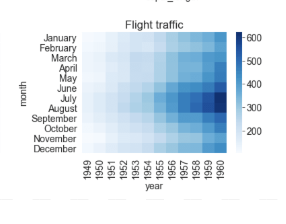

the computational data analysis, sort data or something into heaps? grids? 

this also makes sense:
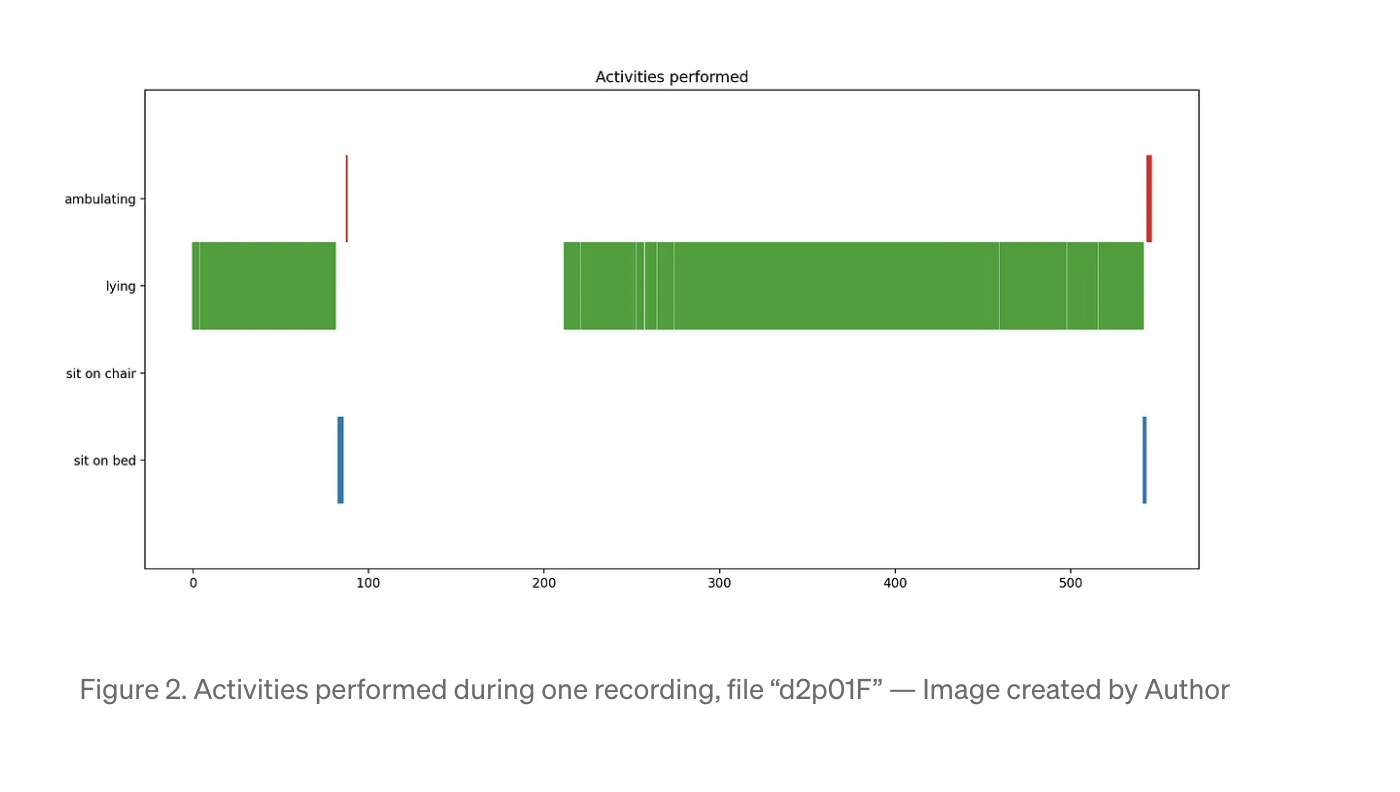

how consistent are the series?
- how much missing in the clean?


make the table similar to the article

correlations for some selected events?
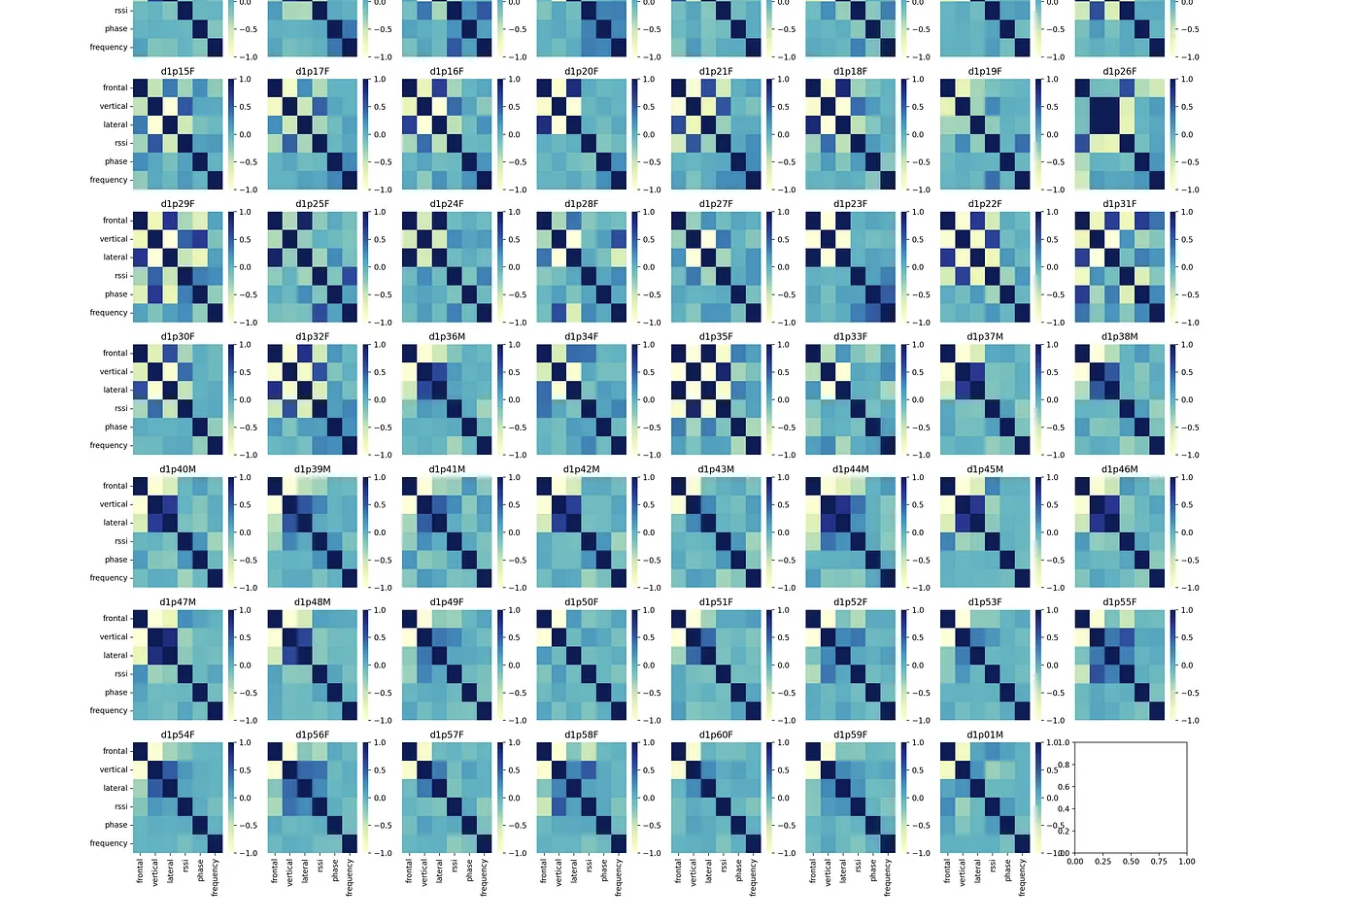

To decide whether to round and to what precision, you need to consider both **the nature of your measurements** (meters, cubic meters per second, amperes) and **the goals of your anomaly detection**. Below is a more specific breakdown to guide your decision:

### 1. **Meters (m)**
   - **Typical Range**: Meters are used for distance or height measurements, which in a sewer context could relate to water levels or infrastructure dimensions.
   - **Precision**: 
     - Rounding to 2 decimal places (e.g., 0.01 m or 1 cm) is often precise enough for measurements in large-scale systems like sewers, where variations below 1 cm may not have significant operational impact.
     - However, if you're tracking very small variations (e.g., detecting minor changes in water levels for early flood detection), consider using 3 decimal places (e.g., 0.001 m or 1 mm) to ensure those small but meaningful changes are captured.
   - **Recommendation**: **2 decimals (0.01 m)** should generally be acceptable, but **3 decimals (0.001 m)** if small changes are critical.

### 2. **Cubic meters per second (m³/s)**
   - **Typical Range**: This metric relates to flow rate, which can vary significantly in sewer systems depending on rainfall, wastewater input, or system conditions.
   - **Precision**: 
     - For large flows, 2 decimals (e.g., 0.01 m³/s) might be sufficient to capture meaningful variations. Small flows, however, might require higher precision if small fluctuations are critical to detecting blockages, leaks, or abnormal conditions.
     - If your system monitors flow rates with a wide range, consider rounding to **3 decimals** to detect smaller anomalies, especially in low-flow situations where even small changes can be important.
   - **Recommendation**: Start with **2 decimals (0.01 m³/s)** but consider going to **3 decimals (0.001 m³/s)** if your system’s sensitivity requires tracking finer variations.

### 3. **Amperes (A)**
   - **Typical Range**: Amperes measure electrical current, which in sewer systems may relate to pump operations, sensor power, or other electrical equipment.
   - **Precision**: 
     - Electrical measurements often need higher precision since even small fluctuations in amperage (e.g., 0.01 A or smaller) can indicate early-stage faults or abnormal equipment behavior.
     - Rounding to 2 decimals might hide subtle but meaningful changes (e.g., 0.015 A) that could indicate electrical issues like wear in pumps or power fluctuations.
     - **3 decimals** (e.g., 0.001 A) may be more appropriate in most cases to retain meaningful data for anomaly detection.
   - **Recommendation**: Use **3 decimals (0.001 A)** for amperes to retain fine details about electrical current behavior.

### General Guidelines for Rounding Decisions:
1. **Start with no rounding** (retain full precision) for anomaly detection purposes, especially during early experiments with your GNN or other AI models.
2. **Assess the nature of your data**:
   - Are you detecting large or small anomalies? If small variations matter, use higher precision (3 decimals).
   - If the range of values varies significantly, avoid rounding initially to capture the full spectrum of possible anomalies.
3. **Test different levels of precision**: 
   - Start by training your models on unrounded data. Once the model’s performance stabilizes, experiment with rounding to see if it affects the anomaly detection accuracy.
   - Rounding might simplify post-modelling output, but doing it too early could affect the model’s ability to catch subtle but important data patterns.

### Suggested Rounding by Metric:
- **Meters (m)**: Round to **2 decimals (0.01 m)**, or **3 decimals (0.001 m)** if high precision is needed.
- **Cubic meters per second (m³/s)**: Round to **2 decimals (0.01 m³/s)**, or **3 decimals (0.001 m³/s)** for finer flow rate detection.
- **Amperes (A)**: Round to **3 decimals (0.001 A)** to detect subtle electrical issues.

### Conclusion:
Avoid rounding during initial AI modelling, particularly for GNN-based anomaly detection, as it preserves as much data precision as possible. If rounding is necessary (for storage, reporting, or post-processing), stick with **2 decimals for meters and flow rates** (m³/s), and **3 decimals for amperes** (A) to maintain a good balance between precision and practicality while retaining meaningful data for analysis.